## Dynamic Movement Primitives (DMP) 

In [1]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as normal_dist
from mixture_model import *
%load_ext autoreload
%autoreload 2

In this demo, we model the letter movement data as Dynamic Movement Primitives. The movement of each variable ($x_1$,$x_2$) is modeled as a spring-damper system, disturbed with nonlinear forcing terms. We learn these forcing terms from the data by using LWR.

#### Load Data 

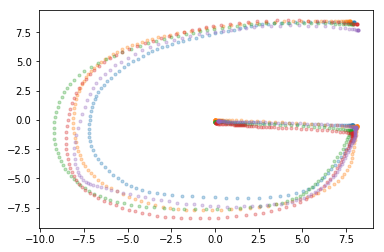

In [2]:
n_samples = 5 #number of demonstrations

ROOT = '../python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]
data = data.transpose([0,2,1])

#plot the data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'.', alpha=0.3)

### Declare Variables 

In [16]:
n_states = 5 #number of states in the GMM
n_out = 2 # Number of motion variables [xi,x2]
n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

#DMP Parameters
Kp = 50 #Stiffness Gain
Kv = np.sqrt(2*Kp) #Damping gain with ideal underdamped damping ratio
alpha = 1. #Decay factor
dt = 0.01 #Length of each trajectory
L = np.hstack([np.eye(n_out)*Kp, np.eye(n_out)*Kv]) #feedback terms
t_in = np.arange(0,n_data*dt,dt) #time 

pos_index = np.arange(0,n_out)
vel_index = np.arange(n_out,2*n_out)
acc_index = np.arange(2*n_out,3*n_out)

#### Compute the velocity and acceleration from the position 

In [17]:
pos_trajs = data.copy()
vel_trajs = np.gradient(pos_trajs, axis=1)/dt
acc_trajs = np.gradient(vel_trajs, axis=1)/dt

### Computing the decay terms 

In [18]:
s_in = np.zeros(n_data) #decay terms
s_in[0] = 1.
for i in range(1,n_data):
    s_in[i] = s_in[i-1] - alpha*s_in[i-1]*dt

### Setting the target

The target here is set as the last point of the demonstration

In [19]:
x_target = data[0][-1]

### Computing the forcing terms 

In [20]:
F = []
for i in range(n_samples):
    f = acc_trajs[i] - Kp*(x_target-pos_trajs[i]) + Kv*vel_trajs[i]
    f = np.divide(f,np.tile(s_in,(2,1)).T)
    F.append(f)
    
F = np.array(F)

### LWR for the forcing terms 

Given the decay variables $s$ and the forcing terms $F$, we want to approximate the mapping $f(s) = F$ by LWR.

#### Set the basis functions variables

In [21]:
t_sep = np.linspace(0.1 + s_in[0],-.1 + s_in[-1],n_states+1)
mus = np.zeros(n_states)
for i in range(n_states):
    mus[i] = 0.5*(t_sep[i]+t_sep[i+1])
sigmas = np.array([2e-3]*n_states)

#### Compute the activation weigths

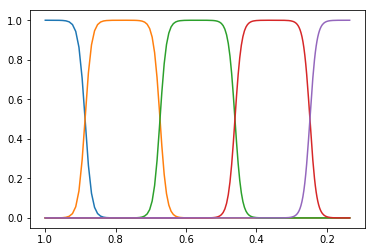

In [22]:
H = np.zeros((n_states, n_data))
for i in range(n_states):
    H[i] = normal_dist(loc = mus[i], scale = np.sqrt(sigmas[i])).pdf(s_in)
H /= np.sum(H,axis=0) #normalizing the weights

for i in range(n_states):
    plt.plot(s_in, H[i],'-')

plt.gca().invert_xaxis()

Hn = np.tile(H,(1,n_samples)) #repeat Hn for n samples

#### Define the input and output 

In [23]:
X = np.tile(np.ones(n_data), (1,n_samples)).T
Y = np.concatenate(F,axis=0)

#### Solve the LWR 

In [24]:
As = []
for i in range(n_states):
    W = np.diag(Hn[i])
    A = dot(inv(dot(X.T,dot(W,X))+1e-5),dot(X.T, dot(W,Y)))
    As.append(A)

#### Given an input, compute the LWR prediction 

In [25]:
#Input
#Xr = s_in[:,None]
Xr = np.ones(n_data)[:,None]

In [26]:
Y_preds = []
for i in range(n_states):
    Y_pred = np.multiply(H[i][:,None], dot(Xr,As[i]))
    Y_preds.append(Y_pred)
    
Y_preds = np.array(Y_preds)
Y_preds = np.sum(Y_preds, axis=0)

#### Plot the prediction 

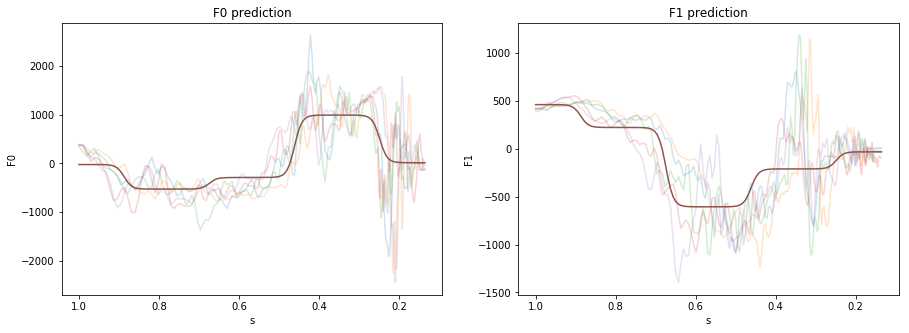

In [36]:
fig,ax = plt.subplots(1,2)

fig.set_size_inches(15,5)

ax[0].set_title('F0 prediction')
ax[1].set_title('F1 prediction')

ax[0].set_xlabel('s')
ax[1].set_xlabel('s')
ax[0].set_ylabel('F0')
ax[1].set_ylabel('F1')

for i in range(n_samples):
    ax[0].plot(s_in, F[i,:,0], '-', alpha=0.2)
    ax[1].plot(s_in, F[i,:,1], '-', alpha=0.2)
ax[0].plot(s_in, Y_preds[:,0])
ax[1].plot(s_in, Y_preds[:,1])
ax[0].invert_xaxis()
ax[1].invert_xaxis()

### Motion retrieval with DMP

Having obtained the forcing terms, we can retrieve the movement by computing the roll-out dynamics of the spring-damper system with the forcing terms.

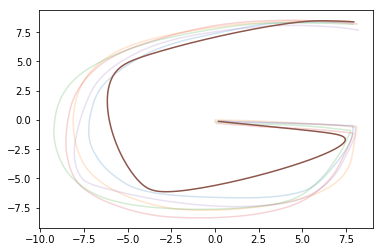

In [28]:
# Initial state
x = data[0,0,:]
dx = np.zeros((1,n_out))

#Compute the dynamics roll-out of the spring-damper system
x_traj = []
for t in range(n_data):
    ddx = Kp*(x_target-x) - Kv*dx + Y_preds[t,:]*s_in[t]
    dx = dx + ddx*dt
    x = x + dx*dt
    x_traj.append(x)

x_traj = np.concatenate(x_traj)


#Plot the resulting motion
for i in range(n_samples):
    plt.plot(data[i,:,0], data[i,:,1], alpha = 0.2)
    
plt.plot(x_traj[:,0], x_traj[:,1])